## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [11]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.8, 0.5, 0.3]
redice_lr_patient = [3, 5, 8]

In [12]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i, optima %s" % (i, reduce_factor, reduce_patient, str(optim)))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor = reduce_factor,
                                  min_lr = 1e-12,
                                  monitor = 'val_loss',
                                  patience = reduce_patient,
                                  verbose = 1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.80, reduce_patient: 3, optima <keras.optimizers.SGD object at 0x000001CA9BED8240>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
________________________

Epoch 11/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.3145 - acc: 0.5404 - val_loss: 1.5068 - val_acc: 0.4724
Epoch 12/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.2909 - acc: 0.5496 - val_loss: 1.4887 - val_acc: 0.4760
Epoch 13/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.2668 - acc: 0.5591 - val_loss: 1.4797 - val_acc: 0.4776
Epoch 14/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.2465 - acc: 0.5662 - val_loss: 1.4749 - val_acc: 0.4790
Epoch 15/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.2248 - acc: 0.5735 - val_loss: 1.4817 - val_acc: 0.4793
Epoch 16/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.2058 - acc: 0.5803 - val_loss: 1.4578 - val_acc: 0.4854
Epoch 17/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.1867 - acc: 0.5879 - val_loss: 1.4518 - val_acc: 0.4885
Epoch 18/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 102us/step - loss: 2.2359 - acc: 0.2622 - val_loss: 2.1705 - val_acc: 0.3011
Epoch 2/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.7595 - acc: 0.3876 - val_loss: 1.9033 - val_acc: 0.3485
Epoch 3/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.6317 - acc: 0.4305 - val_loss: 1.7101 - val_acc: 0.4092
Epoch 4/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.5575 - acc: 0.4559 - val_loss: 1.6455 - val_acc: 0.4256
Epoch 5/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.5037 - acc: 0.4731 - val_loss: 1.6331 - val_acc: 0.4323
Epoch 6/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.4584 - acc: 0.4902 - val_loss: 1.5684 - val_acc: 0.4464
Epoch 7/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.4209 - acc: 0.5045 - val_loss: 1.5476 - val_ac

50000/50000 [==============================] - 4s 79us/step - loss: 1.2303 - acc: 0.5733 - val_loss: 1.4917 - val_acc: 0.4701
Epoch 24/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.2193 - acc: 0.5778 - val_loss: 1.4879 - val_acc: 0.4728
Epoch 25/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.2067 - acc: 0.5841 - val_loss: 1.4826 - val_acc: 0.4748
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 8, optima <keras.optimizers.SGD object at 0x000001CA9BED8240>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
__________________

Epoch 10/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.4569 - acc: 0.4888 - val_loss: 1.5898 - val_acc: 0.4355
Epoch 11/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.4338 - acc: 0.4984 - val_loss: 1.5703 - val_acc: 0.4407
Epoch 12/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.4130 - acc: 0.5056 - val_loss: 1.5600 - val_acc: 0.4474
Epoch 13/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.3935 - acc: 0.5136 - val_loss: 1.5472 - val_acc: 0.4503
Epoch 14/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.3767 - acc: 0.5184 - val_loss: 1.5419 - val_acc: 0.4526
Epoch 15/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.3610 - acc: 0.5235 - val_loss: 1.5306 - val_acc: 0.4580
Epoch 16/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.3431 - acc: 0.5310 - val_loss: 1.5311 - val_acc: 0.4550
Epoch 17/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 111us/step - loss: 2.3519 - acc: 0.2364 - val_loss: 2.2046 - val_acc: 0.2819
Epoch 2/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.8668 - acc: 0.3562 - val_loss: 1.9008 - val_acc: 0.3524
Epoch 3/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.7328 - acc: 0.3949 - val_loss: 1.7857 - val_acc: 0.3810
Epoch 4/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.6581 - acc: 0.4173 - val_loss: 1.7138 - val_acc: 0.4046
Epoch 5/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.6032 - acc: 0.4357 - val_loss: 1.6719 - val_acc: 0.4147
Epoch 6/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.5625 - acc: 0.4498 - val_loss: 1.6550 - val_acc: 0.4205
Epoch 7/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.5278 - acc: 0.4627 - val_loss: 1.6304 - val_ac

50000/50000 [==============================] - 4s 88us/step - loss: 0.4546 - acc: 0.8629 - val_loss: 1.6459 - val_acc: 0.4976
Epoch 22/25
50000/50000 [==============================] - 4s 88us/step - loss: 0.4274 - acc: 0.8733 - val_loss: 1.6425 - val_acc: 0.4998
Epoch 23/25
50000/50000 [==============================] - 4s 90us/step - loss: 0.4043 - acc: 0.8818 - val_loss: 1.6475 - val_acc: 0.5118

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0002621440216898918.
Epoch 24/25
50000/50000 [==============================] - 4s 88us/step - loss: 0.3682 - acc: 0.8983 - val_loss: 1.6512 - val_acc: 0.5132
Epoch 25/25
50000/50000 [==============================] - 4s 86us/step - loss: 0.3454 - acc: 0.9075 - val_loss: 1.6950 - val_acc: 0.5067
Numbers of exp: 10, reduce_factor: 0.80, reduce_patient: 5, optima <keras.optimizers.Adam object at 0x000001CA9A279320>
_________________________________________________________________
Layer (type)                 Output Shape              

50000/50000 [==============================] - 4s 88us/step - loss: 1.2663 - acc: 0.5560 - val_loss: 1.5207 - val_acc: 0.4579
Epoch 6/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.2149 - acc: 0.5758 - val_loss: 1.5240 - val_acc: 0.4587
Epoch 7/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.1708 - acc: 0.5937 - val_loss: 1.4203 - val_acc: 0.4900
Epoch 8/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.1330 - acc: 0.6086 - val_loss: 1.5388 - val_acc: 0.4541
Epoch 9/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.0973 - acc: 0.6220 - val_loss: 1.4213 - val_acc: 0.4944
Epoch 10/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.0632 - acc: 0.6354 - val_loss: 1.4878 - val_acc: 0.4662
Epoch 11/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.0322 - acc: 0.6461 - val_loss: 1.5214 - val_acc: 0.4671
Epoch 12/25
50000/50000 [=========================

50000/50000 [==============================] - 4s 90us/step - loss: 0.8503 - acc: 0.7224 - val_loss: 1.3568 - val_acc: 0.5220
Numbers of exp: 13, reduce_factor: 0.50, reduce_patient: 5, optima <keras.optimizers.Adam object at 0x000001CA9A279320>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_40 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_41 (Batc (None, 256)               1024      
____________________________

50000/50000 [==============================] - 4s 89us/step - loss: 1.5949 - acc: 0.4409 - val_loss: 1.6881 - val_acc: 0.4126
Epoch 12/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.5785 - acc: 0.4478 - val_loss: 1.6827 - val_acc: 0.4157
Epoch 13/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.5660 - acc: 0.4525 - val_loss: 1.6664 - val_acc: 0.4166
Epoch 14/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.5530 - acc: 0.4567 - val_loss: 1.6615 - val_acc: 0.4212
Epoch 15/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.5423 - acc: 0.4599 - val_loss: 1.6496 - val_acc: 0.4256
Epoch 16/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.5302 - acc: 0.4638 - val_loss: 1.6434 - val_acc: 0.4271
Epoch 17/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.5200 - acc: 0.4689 - val_loss: 1.6369 - val_acc: 0.4315
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 145us/step - loss: 2.3511 - acc: 0.2331 - val_loss: 2.1496 - val_acc: 0.2957
Epoch 2/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.9592 - acc: 0.3297 - val_loss: 1.9569 - val_acc: 0.3380
Epoch 3/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.8495 - acc: 0.3611 - val_loss: 1.8810 - val_acc: 0.3567
Epoch 4/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.7847 - acc: 0.3785 - val_loss: 1.8313 - val_acc: 0.3706
Epoch 5/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.7409 - acc: 0.3931 - val_loss: 1.7931 - val_acc: 0.3828
Epoch 6/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.7053 - acc: 0.4067 - val_loss: 1.7706 - val_acc: 0.3914
Epoch 7/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.6768 - acc: 0.4137 - val_loss: 1.7506 - val_ac

Epoch 24/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.4677 - acc: 0.4848 - val_loss: 1.6055 - val_acc: 0.4375
Epoch 25/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.4606 - acc: 0.4871 - val_loss: 1.6009 - val_acc: 0.4388
Numbers of exp: 18, reduce_factor: 0.80, reduce_patient: 3, optima <keras.optimizers.RMSprop object at 0x000001CAA53673C8>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_55 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_______

50000/50000 [==============================] - 4s 88us/step - loss: 1.1931 - acc: 0.5854 - val_loss: 1.5654 - val_acc: 0.4558
Epoch 8/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.1536 - acc: 0.5979 - val_loss: 2.0936 - val_acc: 0.3576
Epoch 9/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.1142 - acc: 0.6151 - val_loss: 1.6824 - val_acc: 0.4140
Epoch 10/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.0740 - acc: 0.6282 - val_loss: 1.6655 - val_acc: 0.4353
Epoch 11/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.0424 - acc: 0.6375 - val_loss: 1.6259 - val_acc: 0.4508
Epoch 12/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.0075 - acc: 0.6530 - val_loss: 1.5479 - val_acc: 0.4670
Epoch 13/25
50000/50000 [==============================] - 4s 89us/step - loss: 0.9729 - acc: 0.6638 - val_loss: 1.5051 - val_acc: 0.4785
Epoch 14/25
50000/50000 [=======================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 152us/step - loss: 1.9635 - acc: 0.3307 - val_loss: 2.0668 - val_acc: 0.3153
Epoch 2/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.6434 - acc: 0.4253 - val_loss: 2.0601 - val_acc: 0.3287
Epoch 3/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.5242 - acc: 0.4660 - val_loss: 1.7745 - val_acc: 0.3971
Epoch 4/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.4385 - acc: 0.4954 - val_loss: 1.7689 - val_acc: 0.3827
Epoch 5/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.3779 - acc: 0.5191 - val_loss: 1.8547 - val_acc: 0.3885
Epoch 6/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.3245 - acc: 0.5351 - val_loss: 1.6603 - val_acc: 0.4182
Epoch 7/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.2784 - acc: 0.5537 - val_loss: 1.6007 - val_ac

Epoch 22/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.3865 - acc: 0.5177 - val_loss: 1.5740 - val_acc: 0.4530
Epoch 23/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.3751 - acc: 0.5227 - val_loss: 1.5658 - val_acc: 0.4549
Epoch 24/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.3633 - acc: 0.5269 - val_loss: 1.5608 - val_acc: 0.4572
Epoch 25/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.3524 - acc: 0.5314 - val_loss: 1.5566 - val_acc: 0.4611
Numbers of exp: 23, reduce_factor: 0.50, reduce_patient: 8, optima <keras.optimizers.RMSprop object at 0x000001CAA53673C8>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688

Epoch 9/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.6399 - acc: 0.4251 - val_loss: 1.7236 - val_acc: 0.4029
Epoch 10/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.6116 - acc: 0.4334 - val_loss: 1.6971 - val_acc: 0.4090
Epoch 11/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.5850 - acc: 0.4444 - val_loss: 1.6804 - val_acc: 0.4185
Epoch 12/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.5624 - acc: 0.4527 - val_loss: 1.6646 - val_acc: 0.4215
Epoch 13/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.5416 - acc: 0.4595 - val_loss: 1.6514 - val_acc: 0.4214
Epoch 14/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.5208 - acc: 0.4658 - val_loss: 1.6381 - val_acc: 0.4298
Epoch 15/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.5021 - acc: 0.4738 - val_loss: 1.6340 - val_acc: 0.4291
Epoch 16/25
50000/50000 [==========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 163us/step - loss: 2.4098 - acc: 0.2154 - val_loss: 2.2666 - val_acc: 0.2569
Epoch 2/25
50000/50000 [==============================] - 4s 89us/step - loss: 2.0831 - acc: 0.2929 - val_loss: 2.0950 - val_acc: 0.2999
Epoch 3/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.9374 - acc: 0.3323 - val_loss: 1.9887 - val_acc: 0.3292
Epoch 4/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.8451 - acc: 0.3594 - val_loss: 1.9191 - val_acc: 0.3459
Epoch 5/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.7790 - acc: 0.3802 - val_loss: 1.8406 - val_acc: 0.3686
Epoch 6/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.7296 - acc: 0.3979 - val_loss: 1.8078 - val_acc: 0.3784
Epoch 7/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.6866 - acc: 0.4106 - val_loss: 1.7721 - val_ac

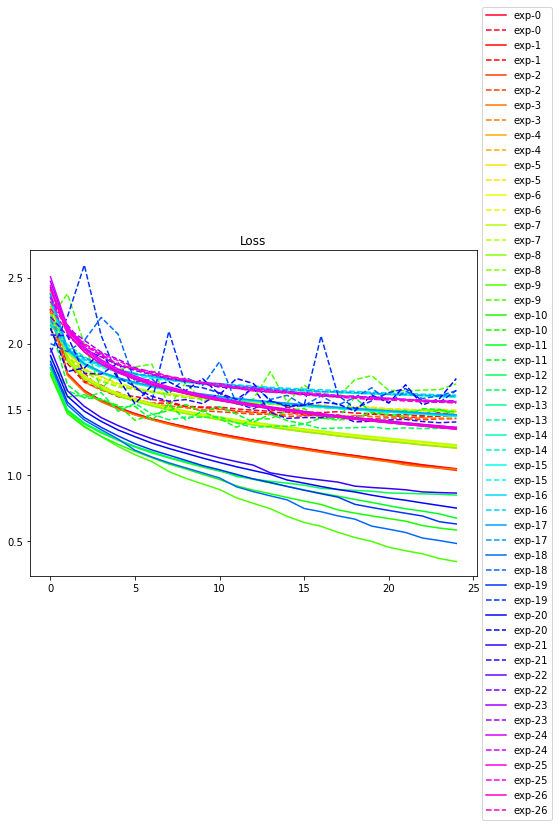

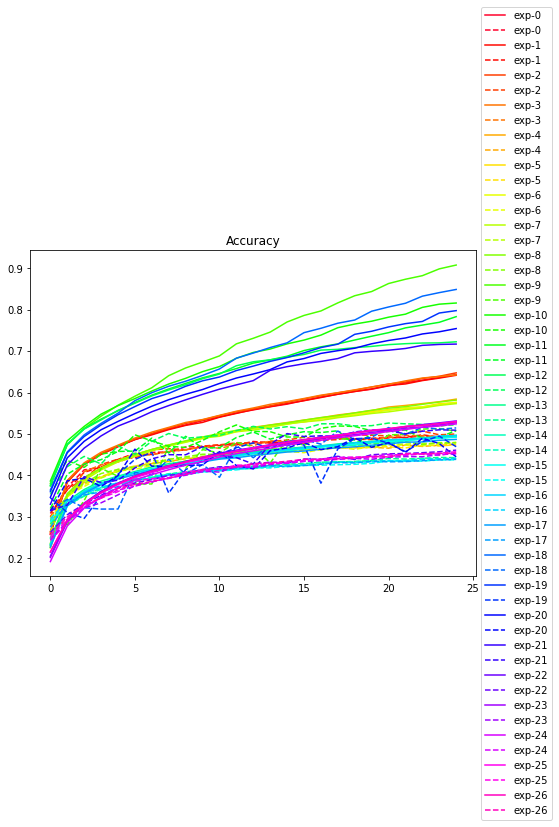

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()